### Loading in Packages

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 103 kB/s 


In [ ]:
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, brier_score_loss, accuracy_score, f1_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split, StratifiedKFold
from scipy.stats import uniform, randint
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from catboost import CatBoostClassifier
import numpy as np
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from lazypredict.Supervised import LazyClassifier

import warnings
warnings.filterwarnings('ignore')

np.random.seed(10)

### Getting the Data from Github

In [ ]:
import urllib.request

diabetes_test = "https://raw.githubusercontent.com/tejseth/diabetes-ml/main/diabetes.csv"

urls = [diabetes_test]
fns = ["diabetes.csv"]
for url, fn in zip(urls, fns):
  urllib.request.urlretrieve(url, fn)

df = pd.read_csv("diabetes.csv")



### Looking at the Dataset



In [ ]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.90,0.17,63,0
764,2,122,70,27,0,36.80,0.34,27,0
765,5,121,72,23,112,26.20,0.24,30,0
766,1,126,60,0,0,30.10,0.35,47,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


In [ ]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

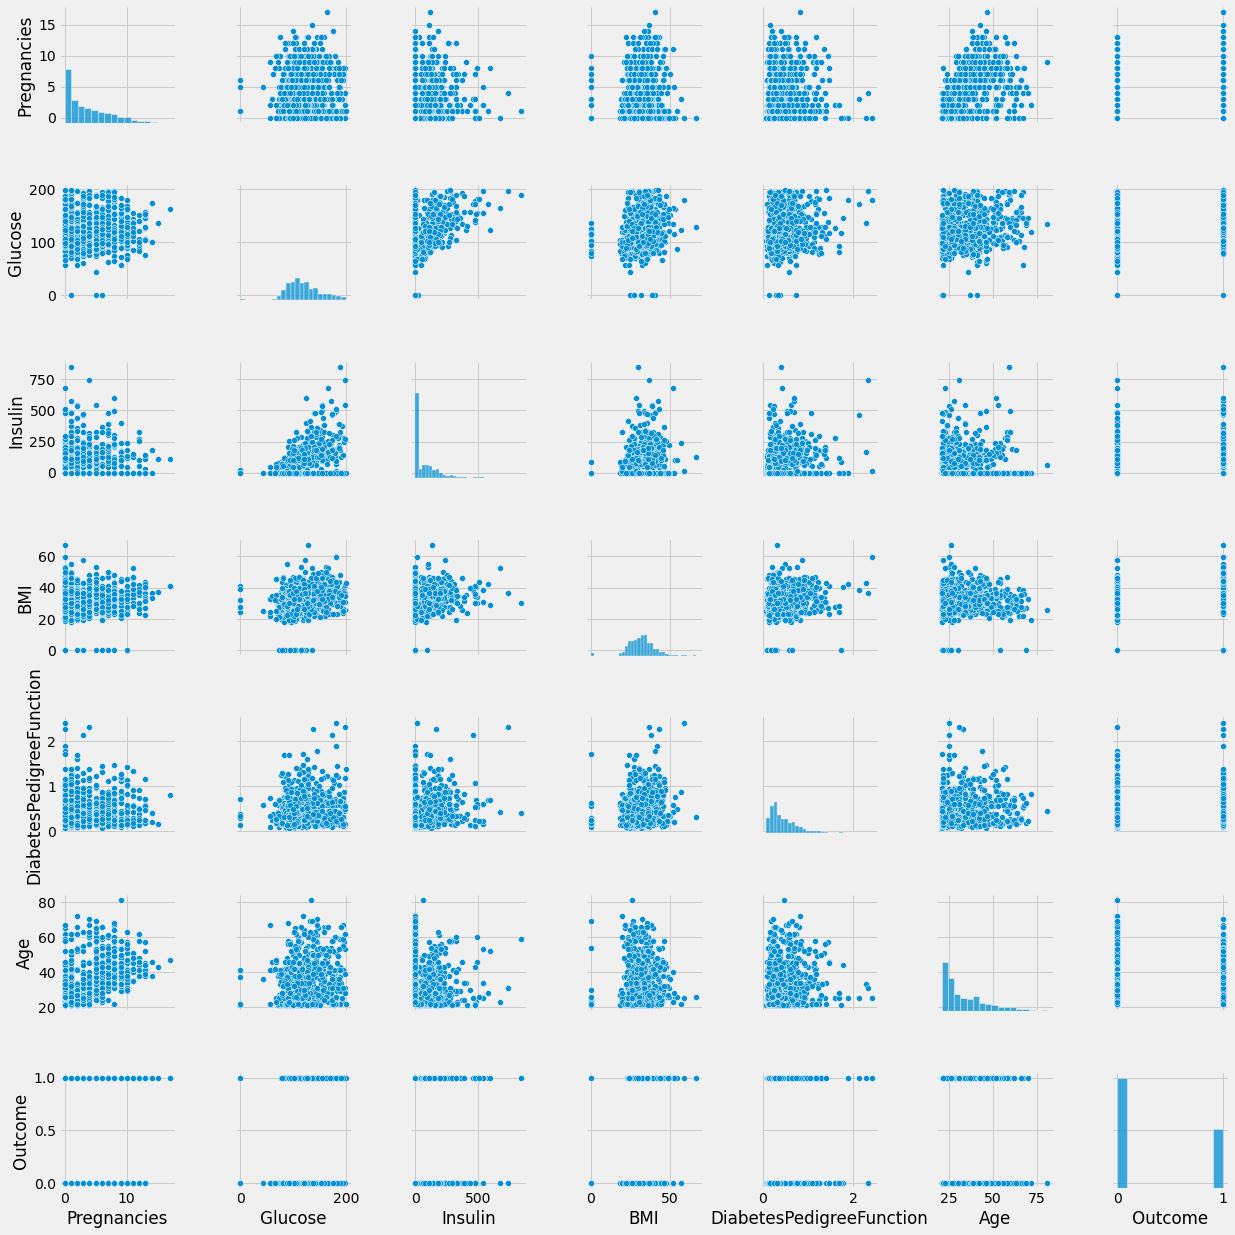

In [ ]:
df1 = df.drop(columns = ['BloodPressure', 'SkinThickness'])
sns.pairplot(df1)
plt.show() 

In [ ]:
df['Glucose_x_BMI'] = df['Glucose'] * df['BMI']
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose_x_BMI
0,6,148,72,35,0,33.60,0.63,50,1,4972.80
1,1,85,66,29,0,26.60,0.35,31,0,2261.00
2,8,183,64,0,0,23.30,0.67,32,1,4263.90
3,1,89,66,23,94,28.10,0.17,21,0,2500.90
4,0,137,40,35,168,43.10,2.29,33,1,5904.70


In [ ]:
df['IsInsulinNonZero'] = np.where(df['Insulin'] == 0, 0, 1)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose_x_BMI,IsInsulinNonZero
0,6,148,72,35,0,33.60,0.63,50,1,4972.80,0
1,1,85,66,29,0,26.60,0.35,31,0,2261.00,0
2,8,183,64,0,0,23.30,0.67,32,1,4263.90,0
3,1,89,66,23,94,28.10,0.17,21,0,2500.90,1
4,0,137,40,35,168,43.10,2.29,33,1,5904.70,1


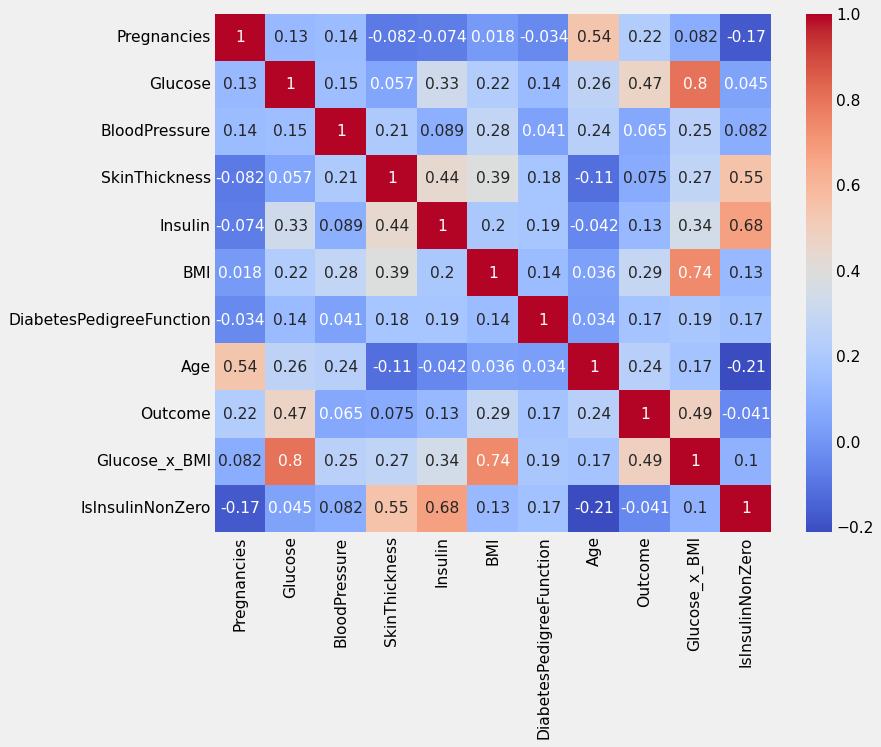

In [ ]:
figure(figsize=(10, 8), dpi=80)
corr_matrix = df.corr()
corr_matrix.round(2)
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)
plt.show()
# corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(3)

### Explanatory Data Analysis

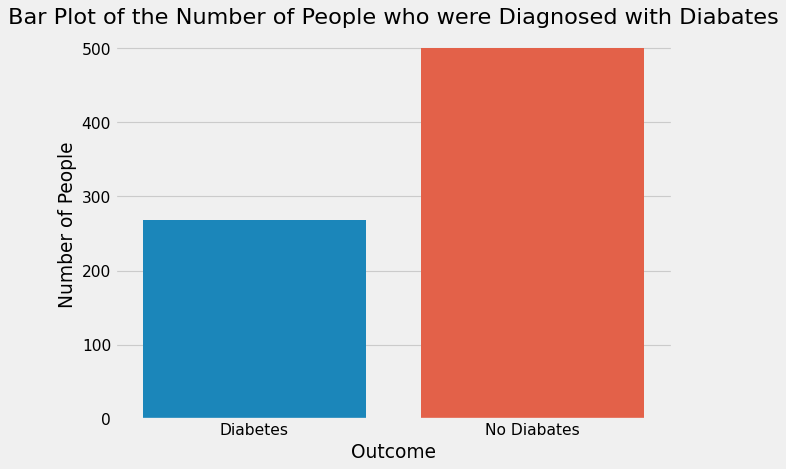

In [ ]:
plt.style.use('fivethirtyeight')
figure(figsize=(8, 6), dpi=80)
df2 = df.copy()
df2['Outcome'] = np.where(df2['Outcome'] == 1,"Diabetes","No Diabates")
sns.countplot(x=df2["Outcome"])
plt.ylabel('Number of People')
plt.title('Bar Plot of the Number of People who were Diagnosed with Diabates', color = "black")
plt.show()

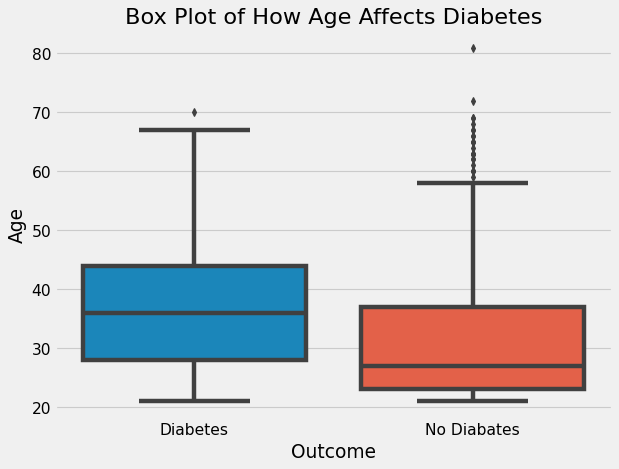

In [ ]:
figure(figsize=(8, 6), dpi=80)
sns.boxplot(y = df['Age'], x = df2['Outcome'])
plt.title('Box Plot of How Age Affects Diabetes', color = "black")
plt.show()

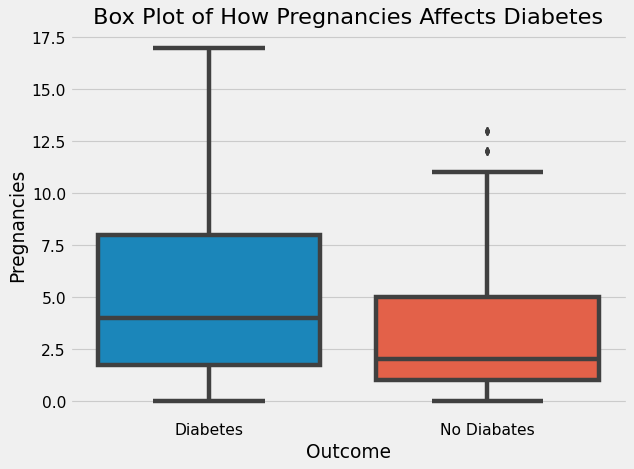

In [ ]:
figure(figsize=(8, 6), dpi=80)
sns.boxplot(y = df['Pregnancies'], x = df2['Outcome'])
plt.title('Box Plot of How Pregnancies Affects Diabetes', color = "black")
plt.show()

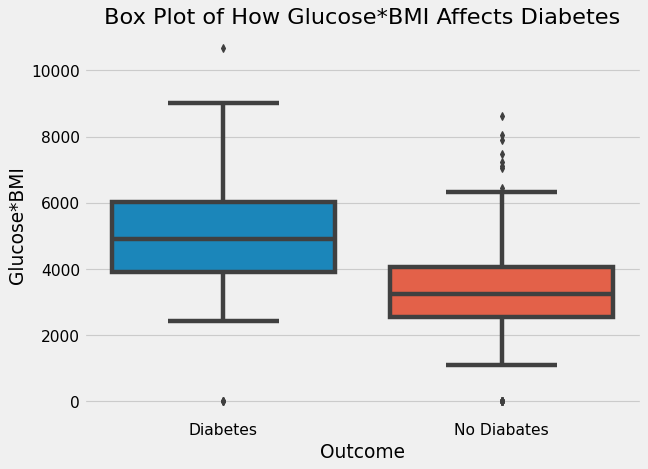

In [ ]:
figure(figsize=(8, 6), dpi=80)
sns.boxplot(y = df2['Glucose_x_BMI'], x = df2['Outcome'])
plt.title('Box Plot of How Glucose*BMI Affects Diabetes', color = "black")
plt.ylabel("Glucose*BMI")
plt.show()

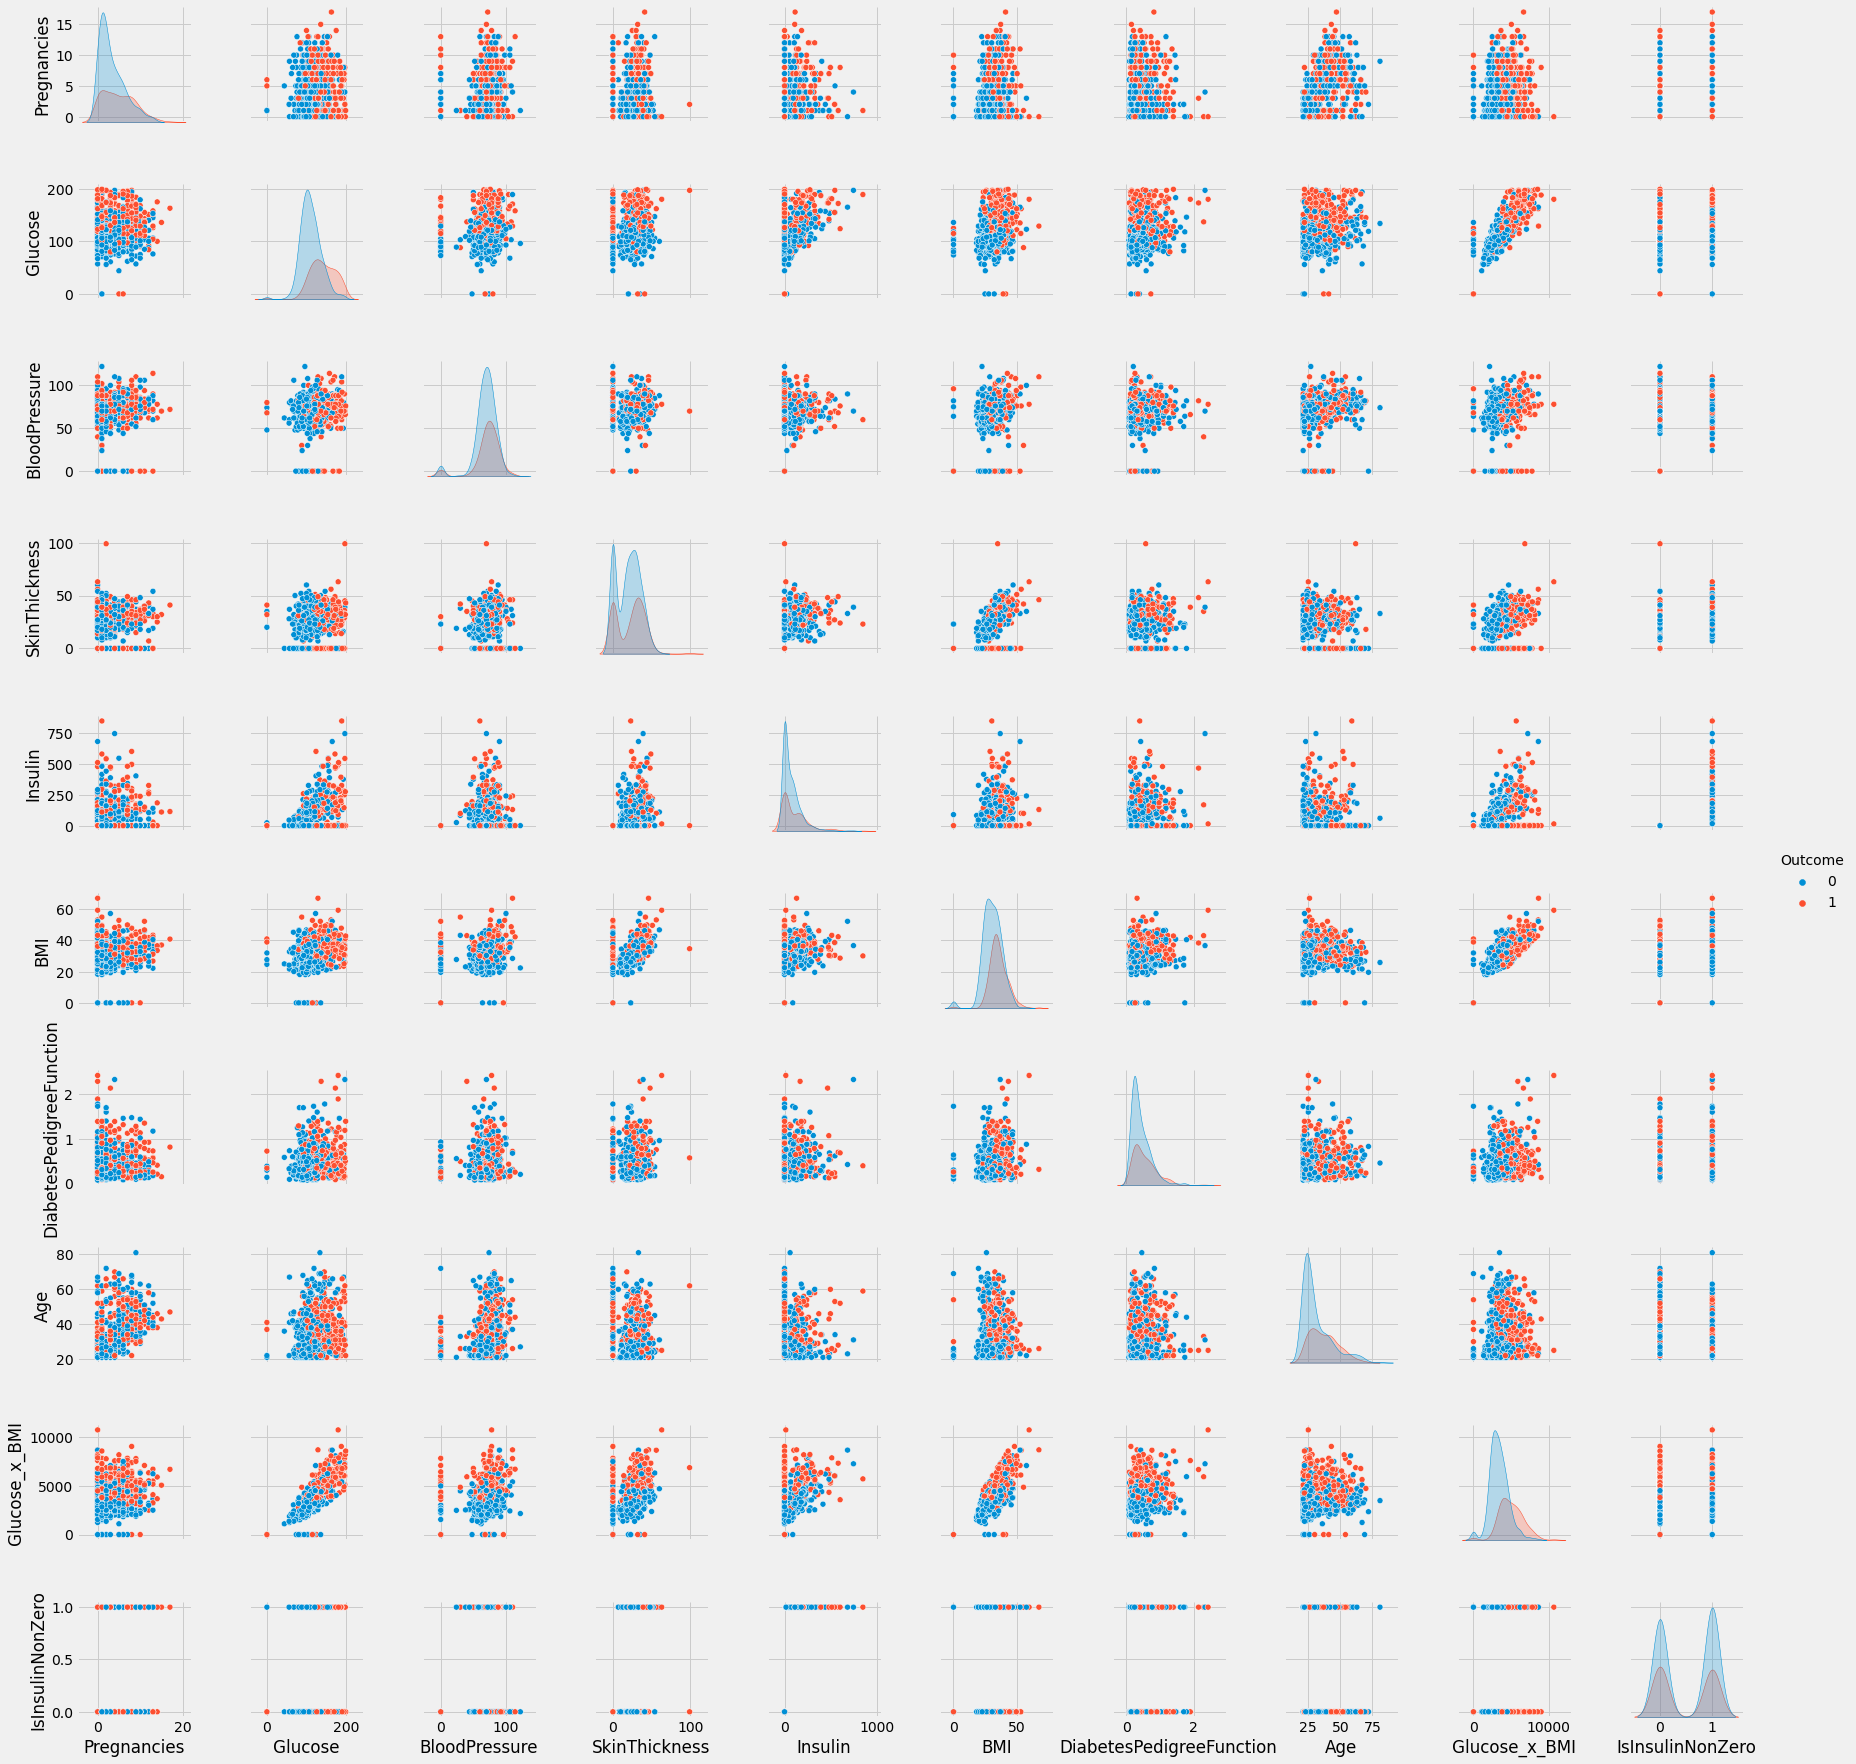

In [ ]:
sns.pairplot(df, hue='Outcome') 

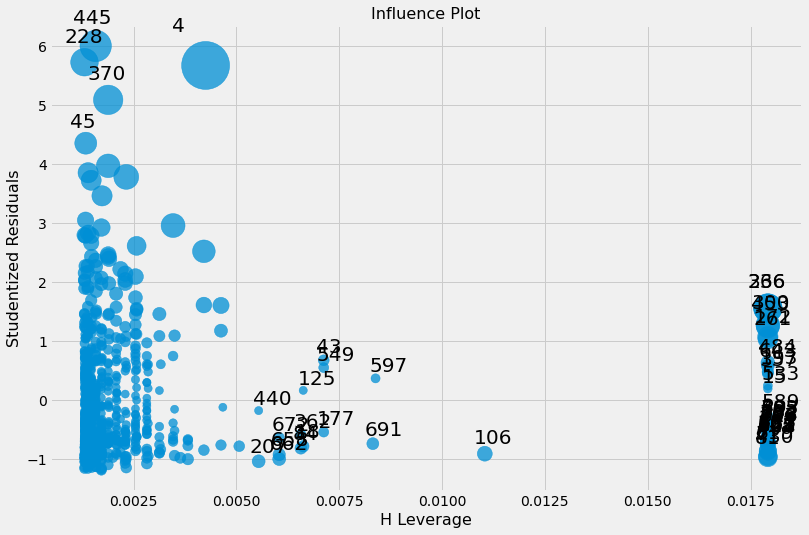

In [ ]:
model0 = smf.ols(" Q('DiabetesPedigreeFunction') ~ Q('BloodPressure')",data=df).fit()
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model0, alpha  = 0.00005, ax = ax, criterion="cooks")

### Making Training and Testing

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_index, test_index in sss.split(df, df['Outcome']):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

X_train = strat_train_set.drop(columns = ['Outcome'])
Y_train = strat_train_set['Outcome']
X_test = strat_test_set.drop(columns = ['Outcome'])
Y_test = strat_test_set['Outcome']

# Making the Models

### Logisitic Regression

In [ ]:
LR = LogisticRegression()
LR.fit(X_train, Y_train)

LR_pred = LR.predict(X_test)

print('Accuracy : ', accuracy_score(Y_test, LR_pred))
print('F1 Score : ', f1_score(Y_test, LR_pred))
print('Brier Score: ', brier_score_loss(Y_test, LR_pred))

Accuracy :  0.7402597402597403
F1 Score :  0.5918367346938775
Brier Score:  0.2597402597402597


### Support Vector Machine

In [ ]:
SVM = svm.SVC(gamma="scale",kernel="rbf")
SVM.fit(X_train, Y_train)

SVM_pred = SVM.predict(X_test)

print('Accuracy : ', accuracy_score(Y_test, SVM_pred))
print('F1 Score : ', f1_score(Y_test, SVM_pred))
print('Brier Score: ', brier_score_loss(Y_test, SVM_pred))

Accuracy :  0.7142857142857143
F1 Score :  0.5319148936170213
Brier Score:  0.2857142857142857


### Random Forest

In [ ]:
RF = RandomForestClassifier()
RF.fit(X_train, Y_train)

RF_pred = RF.predict(X_test)
print('Accuracy : ', accuracy_score(Y_test, RF_pred))
print('F1 Score : ', f1_score(Y_test, RF_pred))
print('Brier Score: ', brier_score_loss(Y_test, RF_pred))

Accuracy :  0.7402597402597403
F1 Score :  0.6078431372549019
Brier Score:  0.2597402597402597


### XGBoost

In [ ]:
XGB = XGBClassifier(objective="binary:logistic", random_state=42)
XGB.fit(X_train, Y_train)

XGB_pred = XGB.predict(X_test)
print('Accuracy : ', accuracy_score(Y_test, XGB_pred))
print('F1 Score : ', f1_score(Y_test, XGB_pred))
print('Brier Score: ', brier_score_loss(Y_test, XGB_pred))

Accuracy :  0.7727272727272727
F1 Score :  0.6464646464646464
Brier Score:  0.22727272727272727


### Tuned XGBoost

In [ ]:
XGB = XGBClassifier(objective="binary:logistic", random_state=42)
XGB.fit(X_train, Y_train)

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(XGB, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_train, Y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


RandomizedSearchCV(cv=3, estimator=XGBClassifier(random_state=42), n_iter=200,
                   n_jobs=1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6870515510>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f68702a9e90>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f68702a9bd0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f68702a9890>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6873b16e90>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6870edc450>},
                   random_state=42, return_train_score=True, verbose=1)

In [ ]:
XGB_tuned = XGBClassifier(objective='binary:logistic',
                          colsample_bytree = search.best_params_['colsample_bytree'],
                          gamma = search.best_params_['gamma'],
                          learning_rate = search.best_params_['learning_rate'],
                          max_depth = search.best_params_['max_depth'],
                          n_estimators = search.best_params_['n_estimators'],
                          subsample = search.best_params_['subsample'],
                         random_state = 42)

XGB_tuned.fit(X_train, Y_train)

XGB_tuned_pred = XGB_tuned.predict(X_test)
print('Accuracy : ', accuracy_score(Y_test, XGB_tuned_pred))
print('F1 Score : ', f1_score(Y_test, XGB_tuned_pred))
print('Brier Score: ', brier_score_loss(Y_test, XGB_tuned_pred))

Accuracy :  0.7272727272727273
F1 Score :  0.5882352941176471
Brier Score:  0.2727272727272727


### Gradient Boosted Classifier

In [ ]:
GBC = GradientBoostingClassifier()
gb_param_grid = {
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=StratifiedKFold(n_splits=10), scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


In [ ]:
GBC_tuned_pred = GBC_best.predict(X_test)
print('Accuracy : ', accuracy_score(Y_test, GBC_tuned_pred))
print('F1 Score : ', f1_score(Y_test, GBC_tuned_pred))
print('Brier Score: ', brier_score_loss(Y_test, GBC_tuned_pred))

Accuracy :  0.7207792207792207
F1 Score :  0.5656565656565656
Brier Score:  0.2792207792207792


### LightGBM

In [ ]:
LGB = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
LGB.fit(X_train,Y_train,eval_set=[(X_test,Y_test),(X_train,Y_train)],
          verbose=20,eval_metric='logloss')

LGB_pred = LGB.predict(X_test)
print('Accuracy : ', accuracy_score(Y_test, LGB_pred))
print('F1 Score : ', f1_score(Y_test, LGB_pred))
print('Brier Score: ', brier_score_loss(Y_test, LGB_pred))

[20]	training's binary_logloss: 0.342278	training's binary_logloss: 0.342278	valid_0's binary_logloss: 0.505645	valid_0's binary_logloss: 0.505645
[40]	training's binary_logloss: 0.224854	training's binary_logloss: 0.224854	valid_0's binary_logloss: 0.509938	valid_0's binary_logloss: 0.509938
[60]	training's binary_logloss: 0.155602	training's binary_logloss: 0.155602	valid_0's binary_logloss: 0.55322	valid_0's binary_logloss: 0.55322
[80]	training's binary_logloss: 0.10827	training's binary_logloss: 0.10827	valid_0's binary_logloss: 0.594853	valid_0's binary_logloss: 0.594853
[100]	training's binary_logloss: 0.0764536	training's binary_logloss: 0.0764536	valid_0's binary_logloss: 0.636609	valid_0's binary_logloss: 0.636609
Accuracy :  0.7597402597402597
F1 Score :  0.6407766990291262
Brier Score:  0.24025974025974026


### CatBoost

In [ ]:
cat_features = [0, 1]

CB = CatBoostClassifier(iterations=100,learning_rate=0.2,depth=10)

CB.fit(X_train, Y_train, cat_features, verbose = False)

CB_pred = CB.predict(X_test)
print('Accuracy : ', accuracy_score(Y_test, CB_pred))
print('F1 Score : ', f1_score(Y_test, CB_pred))
print('Brier Score: ', brier_score_loss(Y_test, CB_pred))

Accuracy :  0.7662337662337663
F1 Score :  0.6470588235294118
Brier Score:  0.23376623376623376


### Checking to Make Sure XGB is Right

In [ ]:
clf = LazyClassifier(verbose = 0, ignore_warnings=True, custom_metric = None)
models, predictions = clf.fit(X_train, X_test, Y_train, Y_test)

print(models)

100%|██████████| 29/29 [00:01<00:00, 17.62it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.77               0.73     0.73      0.77   
BernoulliNB                        0.73               0.72     0.72      0.73   
ExtraTreesClassifier               0.75               0.72     0.72      0.75   
Perceptron                         0.73               0.71     0.71      0.74   
SVC                                0.75               0.70     0.70      0.74   
NuSVC                              0.75               0.70     0.70      0.74   
NearestCentroid                    0.71               0.70     0.70      0.71   
RandomForestClassifier             0.74               0.70     0.70      0.73   
LGBMClassifier                     0.73               0.69     0.69      0.73   
AdaBoostClassifier                 0.73               0.69     0.69      0.72   
DecisionTreeClassifier      

### Make Confusion Matrix for Best Model

<Figure size 640x480 with 0 Axes>

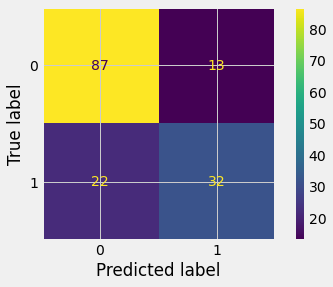

In [ ]:
figure(figsize=(8, 6), dpi=80)
cm = confusion_matrix(Y_test, XGB_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

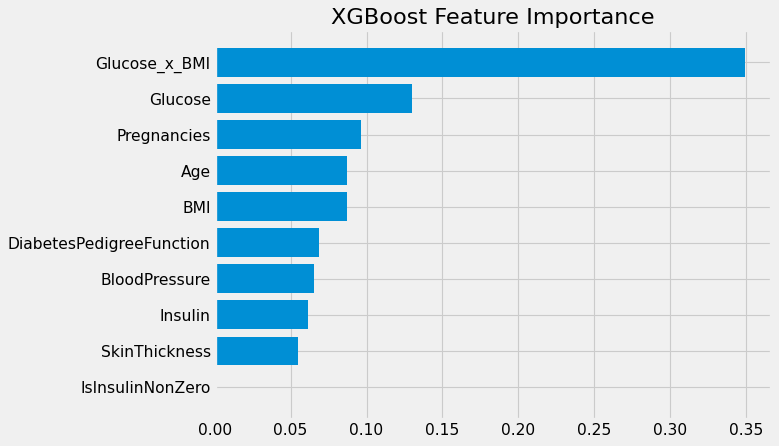

In [ ]:
figure(figsize=(8, 6), dpi=80)
sorted_idx = XGB.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], XGB.feature_importances_[sorted_idx])
plt.title("XGBoost Feature Importance")
plt.show()